In [ ]:
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import more_itertools as mit

from game import *
from player import Player, RandomPlayer, MaxPlayer, MinPlayer, NNPlayer, BonusCravingPlayer, MalusAdverse, GetRidOfBadCards, Robot

In [ ]:
n_player = 3
n_cards = 2

## Training on BonusCraving before evaluating on BonusCraving and then Random

In [ ]:
from player import MCPlayer, SARSAPlayer

In [ ]:
n_game = 5000
game = Game(n_player, n_cards, n_game=1, random=True, verbose=False)
mcp = MCPlayer(name="GuineaPig",n_cards=n_cards)
game.player_list_[0] = mcp
game.player_list_[1] = BonusCravingPlayer("R1",n_cards)
game.player_list_[2] = BonusCravingPlayer("R2",n_cards)
for _ in tqdm(range(n_game)):
    player_list, game_summary, winner_list = game.play()

100%|██████████| 5000/5000 [00:02<00:00, 2468.50it/s]


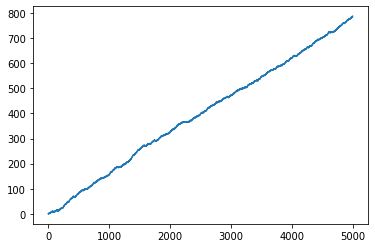

In [ ]:
mcp = game.player_list_[0]
plt.plot(np.cumsum(mcp.game_result))

In [ ]:
mcp.eval()

In [ ]:
for _ in tqdm(range(n_game)):
    player_list, game_summary, winner_list = game.play()

100%|██████████| 5000/5000 [00:00<00:00, 8425.78it/s]


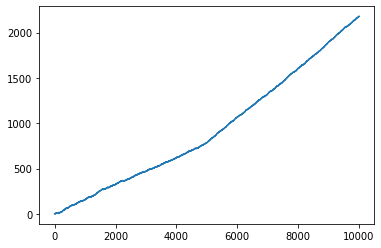

In [ ]:
mcp = game.player_list_[0]
plt.plot(np.cumsum(mcp.game_result))

In [ ]:
game.player_list_[1] = RandomPlayer("R1",n_cards)
game.player_list_[2] = RandomPlayer("R2",n_cards)
for _ in tqdm(range(n_game)):
    player_list, game_summary, winner_list = game.play()

100%|██████████| 5000/5000 [00:00<00:00, 8482.92it/s]


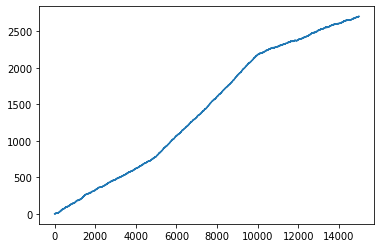

In [ ]:
mcp = game.player_list_[0]
plt.plot(np.cumsum(mcp.game_result))

## Training on Random before evaluating on Random and then BonusCraving

In [ ]:
n_game = 5000
game = Game(n_player, n_cards, n_game=1, random=True, verbose=False)
mcp = MCPlayer(name="GuineaPig",n_cards=n_cards)
game.player_list_[0] = mcp
game.player_list_[1] = RandomPlayer("R1",n_cards)
game.player_list_[2] = RandomPlayer("R2",n_cards)
for _ in tqdm(range(n_game)):
    player_list, game_summary, winner_list = game.play()

100%|██████████| 5000/5000 [00:02<00:00, 2432.42it/s]


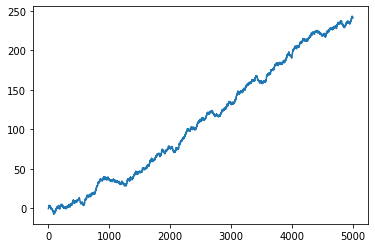

In [ ]:
mcp = game.player_list_[0]
plt.plot(np.cumsum(mcp.game_result))

In [ ]:
mcp.eval()
for _ in tqdm(range(n_game)):
    player_list, game_summary, winner_list = game.play()

100%|██████████| 5000/5000 [00:00<00:00, 8554.59it/s]


In [ ]:
game.player_list_[1] = BonusCravingPlayer("R1",n_cards)
game.player_list_[2] = BonusCravingPlayer("R2",n_cards)
for _ in tqdm(range(n_game)):
    player_list, game_summary, winner_list = game.play()

100%|██████████| 5000/5000 [00:00<00:00, 8367.91it/s]


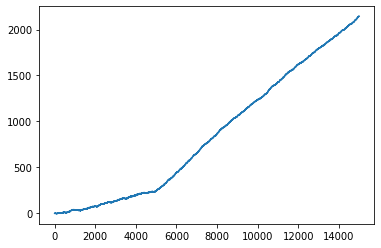

In [ ]:
mcp = game.player_list_[0]
plt.plot(np.cumsum(mcp.game_result))

## SARSA vs MC

In [ ]:
n_game = 5000
n_player = 2
mcp = MCPlayer("MC", n_cards=n_cards)
sarsap = SARSAPlayer("SARSA", n_cards=n_cards)
game = Game(n_player, n_cards, n_game=1, random=True, verbose=False)
game.player_list_[0] = mcp
game.player_list_[1] = sarsap
for _ in tqdm(range(n_game)):
    player_list, game_summary, winner_list = game.play()

100%|██████████| 5000/5000 [00:02<00:00, 1817.22it/s]


In [ ]:
game.n_player_

2

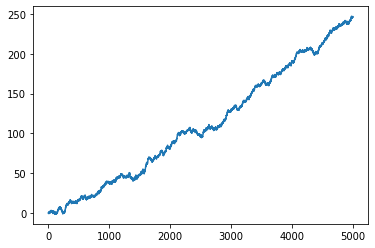

In [ ]:
plt.plot(np.cumsum(mcp.game_result))

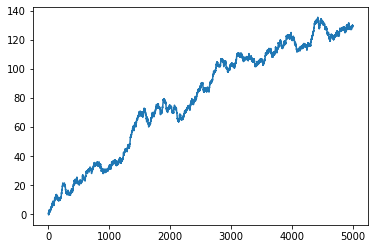

In [ ]:
plt.plot(np.cumsum(sarsap.game_result))

## Interpretation of policy with shap values

In [ ]:
import shap

In [ ]:
policy = mcp.policy
Q = mcp.Q

In [ ]:
def transform_state_to_vector(state):
    card, hand = state
    vector = np.zeros(3*n_cards + 1)
    vector[0] = card
    vector[list(hand)] = 1
    return vector

def transform_vector_to_state(vector):
    card = vector[0]
    hand = np.where(vector != 0)[0][1:]
    return (int(card), tuple(hand))

In [ ]:
state = list(policy.keys())[100]
print(state)
vector = transform_state_to_vector(state)
print(vector)
state_rec = transform_vector_to_state(vector)
print(state_rec)
print(state_rec == state)

(-1, (2, 3, 6))
[-1.  0.  1.  1.  0.  0.  1.]
(-1, (2, 3, 6))
True


In [ ]:
vector.ndim

1

In [ ]:
X = np.stack(list(map(transform_state_to_vector, policy.keys())))
# print(X)
y = np.stack(list(policy.values())).reshape(-1,1)
# print(y)

In [ ]:
for x in X:
    if (x[1:] == 0).all():
        print(x)

In [ ]:
def predict_function_from_Q(Q):
    def predict_function(vector):
        if vector.ndim == 1:
            state = transform_vector_to_state(vector)
            card, hand = state
            if len(hand) == 0:
                return np.zeros(3*n_cards)
            proba_hand = Q[state]
            proba = np.zeros(3*n_cards)
            idx_hand = [card -1 for card in hand]
            proba[idx_hand] = proba_hand
            return proba
        else:
            resu = np.array([predict_function(vec) for vec in vector])
            return resu
    return predict_function

In [ ]:
predictor = predict_function_from_Q(Q)
predictor(vector.reshape(1,-1))

array([[ 0.        , -0.02564103,  0.05128205,  0.        ,  0.        ,
        -0.02083333]])

In [ ]:
# TODO: modèle au lieu de prédire les valeurs prédit les proba
# Explainer à terminer
output_names = list(range(1, 3*n_cards+1))
feature_names = ["card"] + output_names
model = predict_function_from_Q(Q)
explainer = shap.KernelExplainer(model, X, output_names=output_names)

Using 378 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
shap_values = explainer.shap_values(X)

  0%|          | 0/378 [00:00<?, ?it/s]

In [ ]:
shap_values

[array([[-2.39224096e-02,  8.42053088e-03, -1.94998615e-02, ...,
          1.34010263e-02, -2.56181906e-02, -2.88752977e-02],
        [-4.68986705e-03, -2.61242467e-02,  1.43450498e-03, ...,
          7.03250262e-03,  5.31811160e-05, -1.90525571e-03],
        [ 9.39707709e-03,  2.53619458e-02,  1.83759198e-02, ...,
          4.99083200e-02,  8.62845648e-03, -4.80463494e-03],
        ...,
        [-6.46547601e-02,  4.25836983e-03,  1.86130505e-03, ...,
         -9.34356161e-04,  1.31234644e-02, -3.49550987e-02],
        [-2.14091773e-02, -4.61968101e-03, -2.14245149e-03, ...,
          2.70429126e-03, -2.39004931e-05, -1.62275684e-03],
        [-5.96986808e-02,  4.61593381e-03, -1.78488751e-03, ...,
          1.42333568e-02, -1.37663830e-03, -1.37273322e-02]]),
 array([[ 1.35109294e-04, -4.62613480e-03, -3.47546517e-03, ...,
         -7.34734430e-03, -2.49680731e-03, -5.26973306e-04],
        [-6.69709177e-04,  1.60099929e-02,  1.43306033e-02, ...,
         -3.75211386e-02,  9.95212408e

In [ ]:
help(shap.dependence_plot)

Help on function dependence_legacy in module shap.plots._scatter:

dependence_legacy(ind, shap_values=None, features=None, feature_names=None, display_features=None, interaction_index='auto', color='#1E88E5', axis_color='#333333', cmap=None, dot_size=16, x_jitter=0, alpha=1, title=None, xmin=None, xmax=None, ax=None, show=True)
    Create a SHAP dependence plot, colored by an interaction feature.
    
    Plots the value of the feature on the x-axis and the SHAP value of the same feature
    on the y-axis. This shows how the model depends on the given feature, and is like a
    richer extenstion of the classical parital dependence plots. Vertical dispersion of the
    data points represents interaction effects. Grey ticks along the y-axis are data
    points where the feature's value was NaN.
    
    
    Parameters
    ----------
    ind : int or string
        If this is an int it is the index of the feature to plot. If this is a string it is
        either the name of the feature t

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


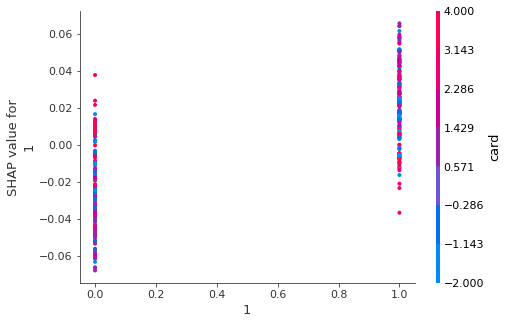

In [ ]:
shap.dependence_plot(1,shap_values[0], X, feature_names=feature_names)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c3570100-157e-4a3f-b5c9-ebc0870008b3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>